In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset
from classificatiom_model import EarlyStopping, ModelSaver
from classificatiom_model import plot_learning_loss_curves,train_regression_model,evaluate_regression_model
import os

In [17]:
# 加载加利福尼亚房价数据集
housing = fetch_california_housing()  # 从sklearn加载加利福尼亚房价数据集
X = housing.data  # 获取特征数据
y = housing.target  # 获取目标变量（房价）

# 数据拆分：训练集(60%)、验证集(20%)、测试集(20%)
# 首先将数据分为训练集(80%)和测试集(20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 使用80%/20%的比例划分训练验证集和测试集

# 然后将训练集再分为训练集(75%，即总数据的60%)和验证集(25%，即总数据的20%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 将训练验证集进一步划分为训练集和验证集

# 打印数据集大小
print(f"训练集大小: {X_train.shape[0]} 样本")  # 显示训练集样本数量
print(f"验证集大小: {X_val.shape[0]} 样本")  # 显示验证集样本数量
print(f"测试集大小: {X_test.shape[0]} 样本")  # 显示测试集样本数量

# 标准化特征
scaler = StandardScaler()  # 创建标准化转换器
X_train_scaled = scaler.fit_transform(X_train)  # 对训练集进行拟合和转换
X_val_scaled = scaler.transform(X_val)  # 使用训练集的参数对验证集进行转换
X_test_scaled = scaler.transform(X_test)  # 使用训练集的参数对测试集进行转换


# %% cell 3 code

# 自定义数据集类
class HousingDataset(Dataset):
    """
    加利福尼亚房价数据集的PyTorch数据集类
    
    参数:
        features: 特征数据
        targets: 目标值
        wide_indices: 用于wide部分的特征索引
        deep_indices: 用于deep部分的特征索引
    """
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)  # 将特征转换为PyTorch张量
        self.targets = torch.FloatTensor(targets).view(-1, 1)  # 确保目标是二维的
    
    def __len__(self):
        return len(self.features)  # 返回数据集的大小
    
    def __getitem__(self, idx):
        # 返回wide特征、deep特征和目标值
        return (self.features[idx],self.features[idx][-2:]), self.targets[idx]

# 创建数据集实例
# 这里我们假设所有特征都用于wide和deep部分
train_dataset = HousingDataset(X_train_scaled, y_train)  # 创建训练数据集
val_dataset = HousingDataset(X_val_scaled, y_val)  # 创建验证数据集
test_dataset = HousingDataset(X_test_scaled, y_test)  # 创建测试数据集

# 创建数据加载器
batch_size = 64  # 设置批次大小
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # 创建训练数据加载器，打乱数据
val_loader = DataLoader(val_dataset, batch_size=batch_size)  # 创建验证数据加载器
test_loader = DataLoader(test_dataset, batch_size=batch_size)  # 创建测试数据加载器

# 检查数据加载器是否正常工作
sample_batch = next(iter(train_loader))  # 获取一个批次的样本
print(f"批次中的特征形状: {[x.shape for x in sample_batch[0]]}")  # 打印特征的形状
print(f"批次中的目标形状: {sample_batch[1].shape}")  # 打印目标的形状


训练集大小: 12384 样本
验证集大小: 4128 样本
测试集大小: 4128 样本
批次中的特征形状: [torch.Size([64, 8]), torch.Size([64, 2])]
批次中的目标形状: torch.Size([64, 1])


In [18]:
from torch import optim  # 导入PyTorch的优化器模块



# 定义神经网络模型
class WideDeepModel(nn.Module):
    def __init__(self, input_dim=(8,2)):
        super().__init__()
        # Deep部分使用Sequential
        self.deep = nn.Sequential(
            nn.Linear(input_dim[1], 30),
            nn.ReLU(),
            nn.Linear(30, 30),
            nn.ReLU()
        )
        
        # Wide部分直接使用原始输入
        
        # 输出层，输入维度是deep部分的30 + wide部分的input_dim
        self.output = nn.Linear(30 + input_dim[0], 1)
        
    def forward(self, x_wide, x_deep):
        # Deep路径，deep shape是[batch_size, 30]
        deep = self.deep(x_deep)
        
        # Wide路径直接使用原始输入
        wide = x_wide
        
        # 连接Wide和Deep,combined shape是[batch_size, 30 + input_dim[0]]
        combined = torch.cat([wide, deep], dim=1)
        
        # 输出层，输出shape是[batch_size, 1]
        output = self.output(combined)
        return output


# 初始化模型、损失函数和优化器
model = WideDeepModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# 打印模型结构
print(model)

WideDeepModel(
  (deep): Sequential(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=38, out_features=1, bias=True)
)


In [19]:
# 训练模型
# 初始化早停和模型保存对象
early_stopping = EarlyStopping(patience=10, verbose=True)
model_saver = ModelSaver(save_dir='model_weights')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 将模型移动到指定设备
model = model.to(device)
# 确保损失函数也在同一设备上
criterion = criterion.to(device)
model, record_dict = train_regression_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=100,
    print_every=10,
    eval_step=500,
    early_stopping=early_stopping,
    model_saver=model_saver,
    device=device.type  # 传递设备类型字符串而不是设备对象
)

train progress:   0%|          | 0/19400 [00:00<?, ?it/s]

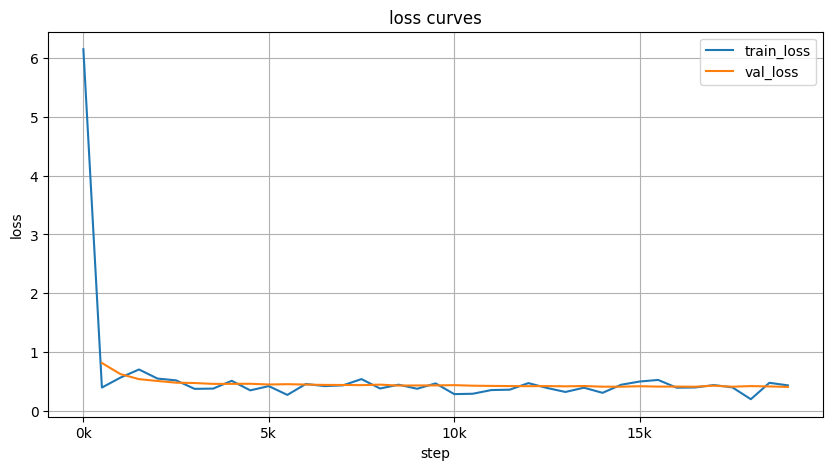

In [20]:
#画图
plot_learning_loss_curves(record_dict,sample_step=500)

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_loss=evaluate_regression_model(model,test_loader,device,criterion)
print(f"测试集上的损失为{test_loss:.4f}")

测试集上的损失为0.4123
